In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from alpha_vantage.timeseries import TimeSeries

In [2]:
api_key = 'GZ6PMA77OKTY8X96'

# Initializing
ts = TimeSeries(key=api_key, output_format='pandas')

# Fetching full daily historical data
data, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')

# Converting index to datetime
data.index = pd.to_datetime(data.index)
data = data.sort_index()

dataa = data.loc["2015-01-01":"2025-07-14"]

dataa = dataa.rename(columns={
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. volume': 'volume'
})

# Reset index to have 'Date' as a column
dataa = dataa.reset_index().rename(columns={'date': 'Date'})
dataa.head()


,Date,open,high,low,close,volume
0,2015-01-02,111.39,111.44,107.350,109.33,53204626.0
1,2015-01-05,108.29,108.65,105.410,106.25,64285491.0
2,2015-01-06,106.54,107.43,104.630,106.26,65797116.0
3,2015-01-07,107.20,108.20,106.695,107.75,40105934.0
4,2015-01-08,109.23,112.15,108.700,111.89,59364547.0


In [3]:
features = ['open', 'high', 'low', 'close', 'volume']
target_column = 'close'
data_target = dataa[features]

In [ ]:
training_size = int(len(data_target) * 0.8)
train_data = data_target[:training_size]
test_data = data_target[training_size:]

# Fit MinMaxScaler on training data only (important!)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)

# Combine last 100 of train with test (for proper sequence windowing in LSTM)
last_100_train = train_data.tail(100)
combined_data = pd.concat([last_100_train, test_data], ignore_index=True)
scaled_test = scaler.transform(combined_data)

In [5]:
def create_sequences(data, window_size=100):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [6]:
X_train, y_train = create_sequences(scaled_train)
X_test, y_test = create_sequences(scaled_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [7]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(100, 1)),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\devg7\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0117
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0037
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.0033
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0022
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - loss: 0.0024
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0013
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0015
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0021
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - loss: 0.0025
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0025
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 0.0014
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0024
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - loss: 0.0027
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 7.8065e-04
Epoch 15/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
full_test = scaled_test[100:]
full_test_inverse = np.zeros((len(predictions), len(features)))
full_test_inverse[:, features.index(target_column)] = predictions.reshape(-1)

predicted_prices = scaler.inverse_transform(full_test_inverse)[:, features.index(target_column)]

actual_test_inverse = np.zeros((len(y_test), len(features)))
actual_test_inverse[:, features.index(target_column)] = y_test
actual_prices = scaler.inverse_transform(actual_test_inverse)[:, features.index(target_column)]

In [16]:
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")


✅ RMSE: 7.04
✅ MAPE: 2.95%


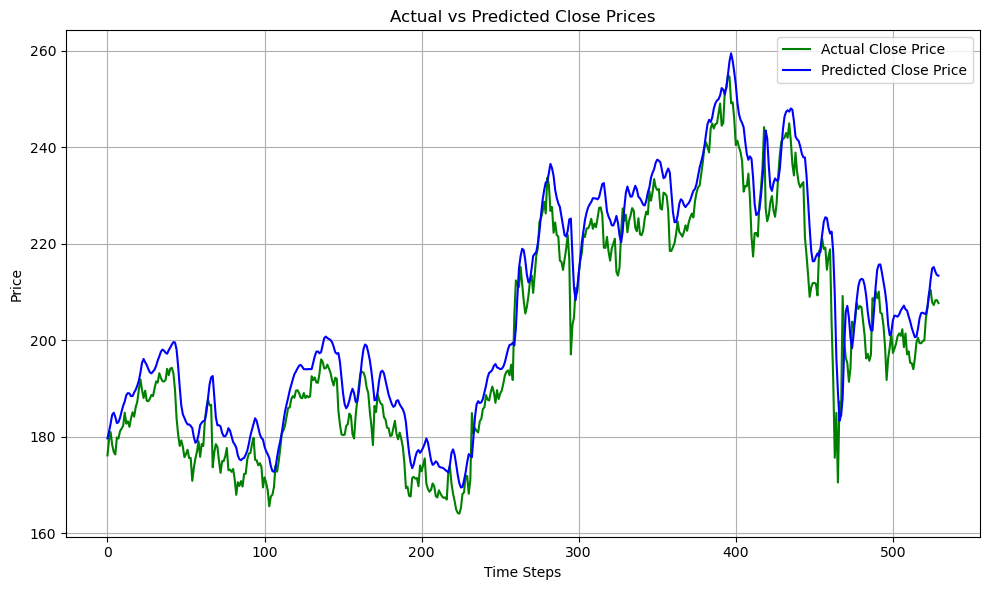

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Close Price', color='green')
plt.plot(predicted_prices, label='Predicted Close Price', color='blue')
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

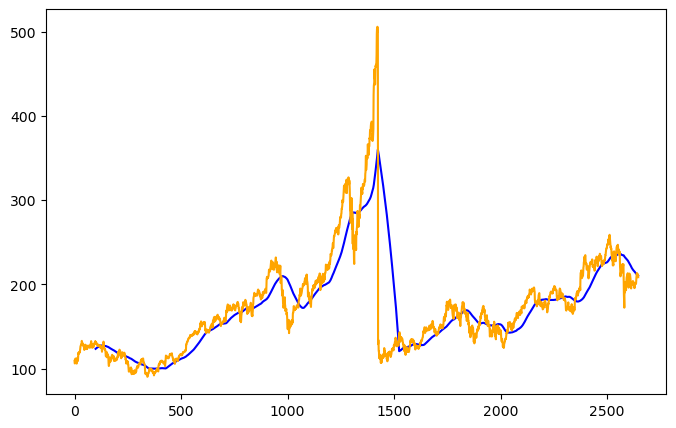

In [19]:
ma_100_days = dataa['close'].rolling(window=100).mean()
plt.figure(figsize=(8, 5))
plt.plot(ma_100_days, label='100-Day Moving Average', color='blue')
plt.plot(dataa.close, label='Close Price', color='orange')
plt.show()

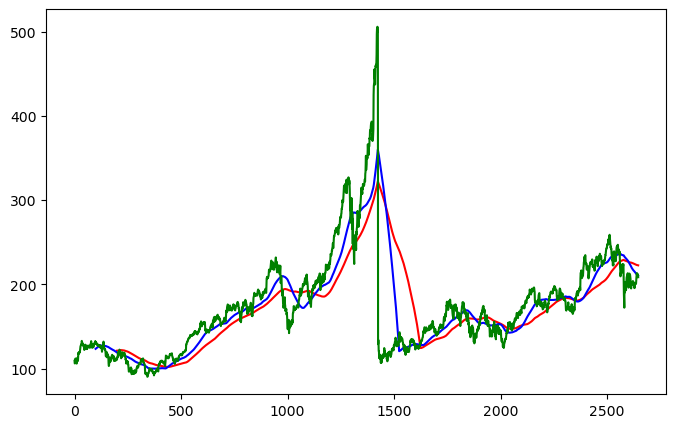

In [20]:
ma_200_days = dataa['close'].rolling(window=200).mean()
plt.figure(figsize=(8, 5))
plt.plot(ma_200_days, label='200-Day Moving Average', color='red')
plt.plot(ma_100_days, label='100-Day Moving Average', color='blue')
plt.plot(dataa.close, label='Close Price', color='green')
plt.show()

In [22]:
summary = {
    "Model": "LSTM 3-layer w/ Dropout",
    "Epochs": len(history.history['loss']),
    "Final Loss": history.history['loss'][-1],
    "RMSE": rmse,
    "MAPE": mape,
    
}
print("\n📊 Summary:")
for k, v in summary.items():
    print(f"{k}: {v}")


📊 Summary:
Model: LSTM 3-layer w/ Dropout
Epochs: 36
Final Loss: 0.0015356738585978746
RMSE: 7.0360949420290675
MAPE: 2.9543348981922657


In [ ]:
#model.save("Stock Predictions Model.keras")
#print("✅ Final model saved as 'Stock Predictions Model.keras'")

✅ Final model saved as 'Stock Predictions Model.keras'
